In [ ]:
import torch
from torch import Tensor
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform) 

In [ ]:

batch_size = 64
# Create data loader for the training dataset
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [12]:
from matplotlib import pyplot as plt
# Function to visualize images
def show_images(images, labels):
    fig, axes = plt.subplots(len(images)//5, 5, figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Value: {label}')
        ax.axis('off')
    plt.show()

# Get a batch of images from the training data loader
data_iter = iter(train_loader)
pictures, true_values = next(data_iter)

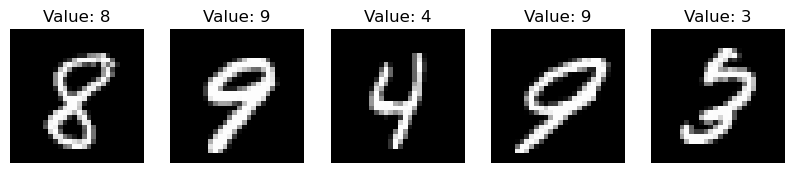

In [15]:
show_images(pictures[10:15], true_values[10:15])

<class 'torch.Tensor'> torch.Size([1, 28, 28])


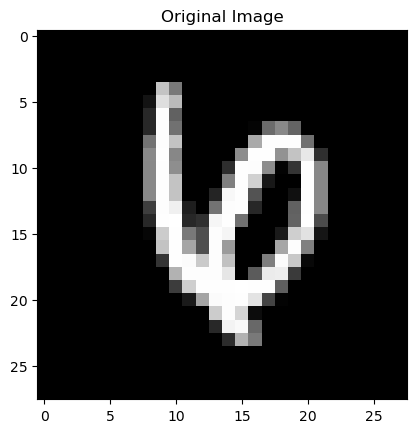

n_patches = 49. 7 rows and 7 columns.


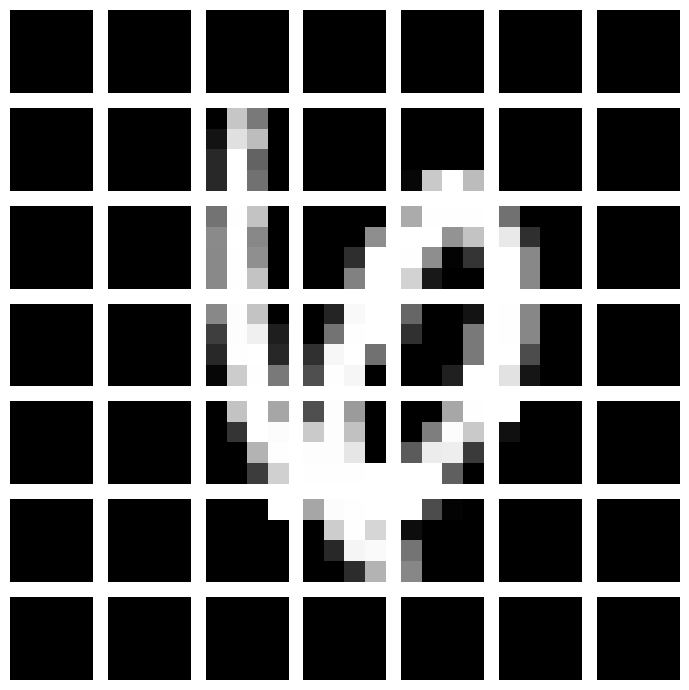

In [100]:
#TODO: [USING VIDEO TUTORIAL ViT]: Split image into quaters using function, translate training set data into splits and feed that into encoder model.

split_image = pictures[0]
# split = #picture is a tensor split into 4 patches (get size of one side, split)
# print(split_image.shape) #torch.Size([1, 28, 28])
print(type(split_image), split_image.shape)

# tensor_image = split_image.view(split_image.shape[1], split_image.shape[2], split_image.shape[0])
# plt.imshow(split_image.permute(1, 2, 0))# same as shaping with view()
# plt.show()
# print("shaped img: ",type(tensor_image), tensor_image.shape)

plt.title("Original Image")
plt.imshow(split_image.squeeze(), cmap='gray')
plt.show()

# def split_into_four(img: Tensor) -> List[Tensor]:
#     C, H, W = img.shape

#     assert H % 2 == 0 and W % 2 == 0 #"Height and Width must be even numbers."
#     top, bottom = torch.split(img, H // 2, dim=1)
#     top_left, top_right = torch.split(top, W // 2, dim=2)
#     bottom_left, bottom_right = torch.split(bottom, W // 2, dim=2)

#     return [top_left, top_right, bottom_left, bottom_right]

# split_image = split_into_four(split_image)

def patch_generator(img: Tensor, patch_size: int) -> List[Tensor]: 
    Img_channel, Img_Height, Img_Width = img.shape 
    
    unfold = nn.Unfold(kernel_size=(patch_size,patch_size), stride=(patch_size,patch_size)) #could stride be patch_size*patch_size
    patches = unfold(img.unsqueeze(0))
    patches = patches.squeeze(0).T
    patches = patches.view(-1, Img_channel, patch_size, patch_size)
    return list(patches)

patches = patch_generator(split_image, patch_size=4) #PATCH_SIZE not defined yet

def show_image(patches, original_img_size, patch_size):  
    n_patches = len(patches)
    cols = rows = original_img_size // patch_size
    print(f"n_patches = {n_patches}. {rows} rows and {cols} columns.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    axes = axes.flatten() #GPT line
    for img, ax in zip(patches, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    
    # Hide any leftover axes
    for ax in axes[n_patches:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_image(patches, 28, 4)

In [43]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 50
LEARNING_RATE = 0.0001
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
# ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4 #encoders in rel life are stacked multiple times
EMBED_DIM = (PATCH_SIZE * PATCH_SIZE) * IN_CHANNELS # 16 = H*W * Channels
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49 = (HWC//Size)^2

#stuff I don't yet understand
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

## Create Image Patches, Convert to Embeddings, CLS Token Classification


In [58]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),                  
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) # -1, -1 do not modify dim

        x = self.patcher(x).permute(0, 2, 1)# image reshape 
        x = torch.cat([cls_token, x], dim=1) #merge cls_tok w/ patches
        x = self.position_embeddings + x 
        x = self.dropout(x)
        return x
    
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device) #dummy input for checking work. BATCH_SIZE, INPUT_CHANNELS, IMG_HEIGHT, IMG_WIDTH
print(model(x).shape) # model weights, layers and  
### 512 - BATCH SIZE , 50 tokens => 49 patches as tokens + 1 cls token, 16 - Size of Patches

torch.Size([512, 50, 16])


## Building Vision Transformer Model (on top of Patches Class)


In [ ]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[: , 0 , :]) #mlp head needs to take token only
        # REMEBER THAT THE CLS TOKEN AT POSN 0 IS A LEARNABLE Feature and its value is influenced by every other (token+img) combo in the "list".
        # one more layer, a softmax output perhaps? GPT/instructor: Activation fn is for inference not for training, we want to preserve raw logits everywhere else. I was assuming inference too early on.
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE, NUM_CLASSES

c:\Users\Joshua\anaconda3\envs\MLI\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([512, 10])


## Training Preparation


In [61]:
import pandas as pd
from torch import optim
from sklearn.model_selection import train_test_split